In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import piq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from pathlib import Path
import torch
import os, sys
from tqdm import tqdm
import shutil
import seaborn as sns
import pickle

In [3]:
IMAGES_REF = Path('iqa/tid2013/reference_images')
IMAGES_DIS = Path('iqa/tid2013/distorted_images')
IMAGES_SAL = Path('iqa/tid2013/saliency')

In [4]:
def imread(path):
    image = cv2.imread(str(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = torch.Tensor(image) / 255
    return image

def to_tensor(image):
    return image.permute(2, 0, 1).unsqueeze(0)

In [5]:
df = pd.read_csv('/home/alexkkir/experiments-with-saliency/iqa/tid2013_data.csv')
df['ssim'] = .0
df['ssim_sal'] = .0

In [6]:
def modify_mask(mask, alpha=0.85):
    mask = mask * alpha + (1 - alpha)
    return mask

In [7]:
device = torch.device('cuda:3')

for i in tqdm(range(len(df))):
    file_dis = df.loc[i, 'name']
    file_ref = file_dis.split('_')[0] + '.' + file_dis.split('.')[-1]
    ref = imread(IMAGES_REF / file_ref)
    dis = imread(IMAGES_DIS / file_dis)
    sal = imread(IMAGES_SAL / file_dis.replace('.bmp', '.jpeg'))

    sal = modify_mask(sal, alpha=1)
    
    ref = to_tensor(ref).to(device)
    dis = to_tensor(dis).to(device)
    sal = to_tensor(sal).to(device)

    before = float(piq.ssim(ref, dis))
    df.loc[i, 'ssim'] = before

    after = float(piq.ssim(ref, dis, sal))
    df.loc[i, 'ssim_sal'] = after

100%|██████████| 3000/3000 [00:34<00:00, 87.55it/s] 


In [22]:
def calc_corr(df, mode='pearson'):
    grouped = df.groupby('sequence').mean()
    for seq in grouped.index:
        grouped.loc[seq, 'corr_common'] = df[df.sequence == seq].corr(mode).loc['subj_mean', 'ssim']
        grouped.loc[seq, 'corr_sal'] = df[df.sequence == seq].corr(mode).loc['subj_mean', 'ssim_sal']
    return grouped

calc_corr(df, 'spearman').mean()

subj_mean      4.474657
subj_std       0.131600
ssim           0.868448
ssim_sal       0.877838
corr_common    0.744234
corr_sal       0.823082
dtype: float64

In [23]:
def make_experiment(df, alpha):
    for i in (range(len(df))):
        file_dis = df.loc[i, 'name']
        file_ref = file_dis.split('_')[0] + '.' + file_dis.split('.')[-1]
        ref = imread(IMAGES_REF / file_ref)
        dis = imread(IMAGES_DIS / file_dis)
        sal = imread(IMAGES_SAL / file_dis.replace('.bmp', '.jpeg'))

        sal = modify_mask(sal, alpha)
        
        ref = to_tensor(ref).to(device)
        dis = to_tensor(dis).to(device)
        sal = to_tensor(sal).to(device)

        # before = float(piq.ssim(ref, dis))
        # df.loc[i, 'ssim'] = before

        after = float(piq.ssim(ref, dis, sal))
        df.loc[i, 'ssim_sal'] = after

    out = calc_corr(df, 'spearman').mean()['corr_sal']
    return out

In [12]:
alpha_space = np.linspace(0.8, 1, 10)
out = {}
for alpha in tqdm(alpha_space):
    result = make_experiment(df, alpha)
    out[alpha] = result

100%|██████████| 10/10 [04:14<00:00, 25.41s/it]


Text(0.5, 1.0, 'Как подобрать коэффициент $\\alpha$ в формуле\n $mask = mask \\cdot \\alpha + (1 - \\alpha)$')

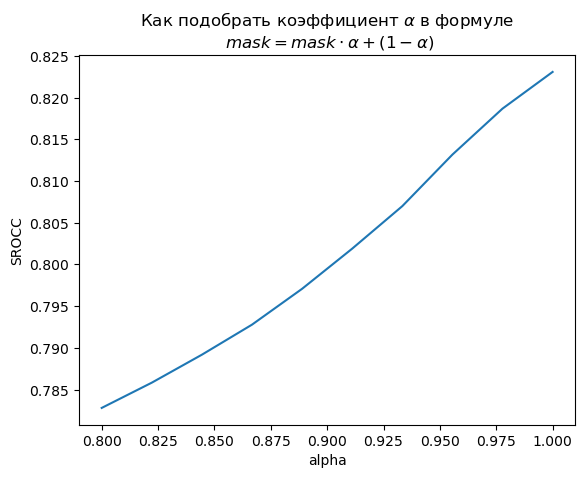

In [13]:
plt.plot(out.keys(), out.values())
plt.xlabel('alpha')
plt.ylabel('SROCC')
plt.title('Как подобрать коэффициент $\\alpha$ в формуле\n $mask = mask \cdot \\alpha + (1 - \\alpha)$')

In [24]:
calc_corr(df, 'pearson')

,subj_mean,subj_std,ssim,ssim_sal,corr_common,corr_sal
sequence,,,,,,
i01,4.470368,0.134118,0.888211,0.878995,0.772873,0.834554
i02,4.472146,0.121983,0.810641,0.816174,0.777154,0.869953
i03,4.480565,0.113507,0.825084,0.809404,0.693063,0.786295
i04,4.488106,0.105198,0.820332,0.830750,0.722439,0.806380
i05,4.471393,0.141207,0.920474,0.927985,0.766955,0.777288
i06,4.476146,0.144028,0.884125,0.897676,0.835608,0.813660
i07,4.477217,0.122225,0.880822,0.874315,0.805444,0.833522
i08,4.473357,0.159319,0.920517,0.923154,0.758407,0.780196
i09,4.469769,0.135184,0.866958,0.881073,0.707307,0.818375


Text(0.5, 1.0, 'Как улучшается srocc в зависимости от разброса оценок')

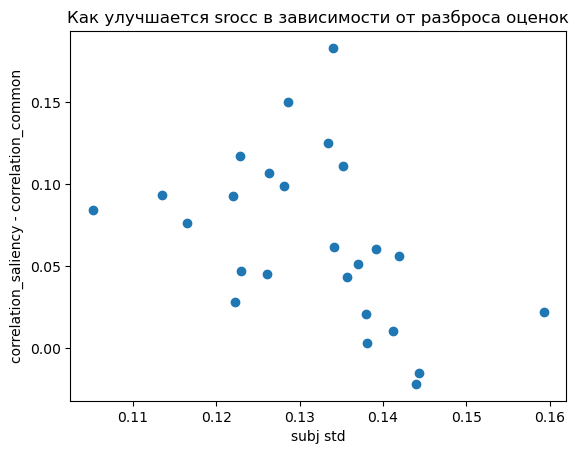

In [29]:
tmp = calc_corr(df, 'pearson')
plt.scatter(tmp.subj_std, tmp.corr_sal - tmp.corr_common)
plt.xlabel('subj std')
plt.ylabel('correlation_saliency - correlation_common')
plt.title('Как улучшается srocc в зависимости от разброса оценок')